# Automatically generating object masks with SAM

Since SAM can efficiently process prompts, masks for the entire image can be generated by sampling a large number of prompts over an image. This method was used to generate the dataset SA-1B. 

The class `SamAutomaticMaskGenerator` implements this capability. It works by sampling single-point input prompts in a grid over the image, from each of which SAM can predict multiple masks. Then, masks are filtered for quality and deduplicated using non-maximal suppression. Additional options allow for further improvement of mask quality and quantity, such as running prediction on multiple crops of the image or postprocessing masks to remove small disconnected regions and holes.

## Set-up

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import os
from pathlib import Path

def draw_bbox(image, masks):
    for mask in masks:
        x, y, w, h = map(int, mask["bbox"])
        cv2.rectangle(image, (x, y), (x+w, y+h), np.random.random(3), 2)
    return image

def merge_mask(masks, tolerance = 10):
    # The tolerance is in pixels
    merged_masks=[]
    merged_indices = set()

    for i in range(len(masks)):
        if i in merged_indices: continue
        bbox    = masks[i]['bbox']
        current_left   = int(bbox[0])
        current_top    = int(bbox[1])
        current_right  = int(bbox[0] + bbox[2])
        current_buttom = int(bbox[1] + bbox[3])

        for j in range(i+1,len(masks)):
            if j in merged_indices: continue
            bbox        = masks[j]['bbox']
            next_left   = int(bbox[0])
            next_top    = int(bbox[1])
            next_right  = int(bbox[0] + bbox[2])
            next_buttom = int(bbox[1] + bbox[3])

            if (( abs(current_top - next_top)       < tolerance and
                  abs(current_buttom - next_buttom) < tolerance and
                 (abs(current_right - next_left)    < tolerance or abs(current_left - next_right) < tolerance))
                or
                ( abs(current_right - next_right) < tolerance and
                  abs(current_left - next_left)   < tolerance and
                 (abs(current_top - next_buttom)  < tolerance or abs(next_top - current_buttom) < tolerance))):
                
                merged_indices.add(j)
                new_mask=masks[i].copy()
                new_mask['segmentation'][:,:] = masks[i]['segmentation'][:,:]+masks[j]['segmentation'][:,:]
                new_mask['area']              = masks[i]['area'] + masks[j]['area']
                new_mask['bbox'][0]           = min(current_left,next_left)
                new_mask['bbox'][1]           = min(current_top,next_top)
                new_mask['bbox'][2]           = max(current_right,next_right)-new_mask['bbox'][0]
                new_mask['bbox'][3]           = max(current_buttom,next_buttom)-new_mask['bbox'][1]
                # take the arithmetic mean, it might be inaccurate
                new_mask['predicted_iou']     = (masks[i]['predicted_iou'] + masks[j]['predicted_iou'])/2.0
                new_mask['stability_score']   = (masks[i]['stability_score'] + masks[j]['stability_score'])/2.0
                # keep both
                for point_coords in masks[j]['point_coords']:
                    new_mask['point_coords'].append(point_coords)
                
                merged_masks.append(new_mask)
                break
        else: # if can't merge
            merged_masks.append(masks[i])

    return merged_masks

def get_grid_info(points,tolerance=30):
    # tolerance is in pixel
    def get_cluster_center(values):       
        grouped_indices = set()
        cluster_center = []
        
        while True:
            reference_values = []
            for i in range(len(values)):
                if i in grouped_indices:
                    continue
                reference_values.append(values[i])
                grouped_indices.add(i)
                break
            else: break
            
            grouping_completed = False
            while not grouping_completed:
                grouping_completed = True
                i = 0
                while i < len(reference_values):
                    for j in range(len(values)):
                        if j not in grouped_indices and abs(reference_values[i] - values[j]) < tolerance:
                            reference_values.append(values[j])
                            grouped_indices.add(j)
                            grouping_completed = False
                    i += 1

            cluster_center.append(sum(reference_values) / len(reference_values))

        cluster_center.sort()
        return cluster_center
    
    col_x = get_cluster_center([point[0] for point in points])
    row_y = get_cluster_center([point[1] for point in points])

    col_width = []
    for i in range(len(col_x)-1):
        col_width.append(col_x[i+1] - col_x[i])
    grouped_col_width = min(get_cluster_center(col_width))

    avg_col_width = grouped_col_width
    
    row_height = []
    for i in range(len(row_y)-1):
        row_height.append(row_y[i+1] - row_y[i])
    avg_row_height = min(get_cluster_center(row_height))

    display_x      = int(min(col_x) - avg_col_width/2)
    display_y      = int(min(row_y) - avg_row_height/2)
    display_width  = int(max(col_x) + avg_col_width/2 - display_x)
    display_height = int(max(row_y) + avg_row_height/2 - display_y)
    m = round((max(row_y)-min(row_y))/avg_row_height+1)
    n = round((max(col_x)-min(col_x))/avg_col_width+1)
    
    return (display_x, display_y, display_width, display_height), (m,n)

def get_symbol_ROI(grid_bbox, grid_shape) :
    x, y, width, height = grid_bbox
    row = grid_shape[0]
    col = grid_shape[1]
    
    width -= width % col
    height -= height % row
    symbol_width = width / col
    symbol_height = height / row

    symbol_width = width / col
    symbol_height = height / row
    
    frames = []
    for i in range(col):
        for j in range(row):
            frames.append([int(x+symbol_width*i),int(y+symbol_height*j),int(symbol_width),int(symbol_height)])
    
    # output = open("game_symbol_ROIs.json","w")
    # print(frames,file=output)
    # output.close()
    
    return frames

In [2]:
GAME_NAME = 'fu'

image = cv2.imread(f'../images/{GAME_NAME}/1.png')
image_copy = image.copy()
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

## Automatic mask generation

To run automatic mask generation, provide a SAM model to the `SamAutomaticMaskGenerator` class. Set the path below to the SAM checkpoint. Running on CUDA and with the default model is recommended.

In [6]:
import sys
sys.path.append("..")
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

device = "cuda"
sam2_checkpoint = "../checkpoints/sam2_hiera_large.pt"
model_cfg = "sam2_hiera_l.yaml"

sam2 = build_sam2(model_cfg, sam2_checkpoint, device=device, apply_postprocessing=False)

print("Model loaded")

Model loaded


Mask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:
* `segmentation` : the mask
* `area` : the area of the mask in pixels
* `bbox` : the boundary box of the mask in XYWH format
* `predicted_iou` : the model's own prediction for the quality of the mask
* `point_coords` : the sampled input point that generated this mask
* `stability_score` : an additional measure of mask quality
* `crop_box` : the crop of the image used to generate this mask in XYWH format

## Automatic mask generation options

There are several tunable parameters in automatic mask generation that control how densely points are sampled and what the thresholds are for removing low quality or duplicate masks. Additionally, generation can be automatically run on crops of the image to get improved performance on smaller objects, and post-processing can remove stray pixels and holes. Here is an example configuration that samples more masks:

In [7]:
mask_generator = SAM2AutomaticMaskGenerator(
    model=sam2,
)

masks = mask_generator.generate(image)

# print(len(masks))
# draw_bbox(image_copy, masks)
# plt.figure(figsize=(20,20))
# plt.imshow(image_copy)
# plt.axis('off')
# plt.show()

c:\Users\pppoo\Desktop\SAM2\src\..\sam2\modeling\backbones\hieradet.py:68: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  x = F.scaled_dot_product_attention(
c:\Users\pppoo\Desktop\SAM2\src\..\sam2\modeling\sam\transformer.py:270: UserWarning: Memory efficient kernel not used because: (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:723.)
  out = F.scaled_dot_product_attention(q, k, v, dropout_p=dropout_p)
c:\Users\pppoo\Desktop\SAM2\src\..\sam2\modeling\sam\transformer.py:270: UserWarning: Memory Efficient attention has been runtime disabled. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen/native/transformers/sdp_utils_cpp.h:495.)
  out = F.scaled_dot_product_attention(q, k, v, dr

before merge: 131
after merge: 121


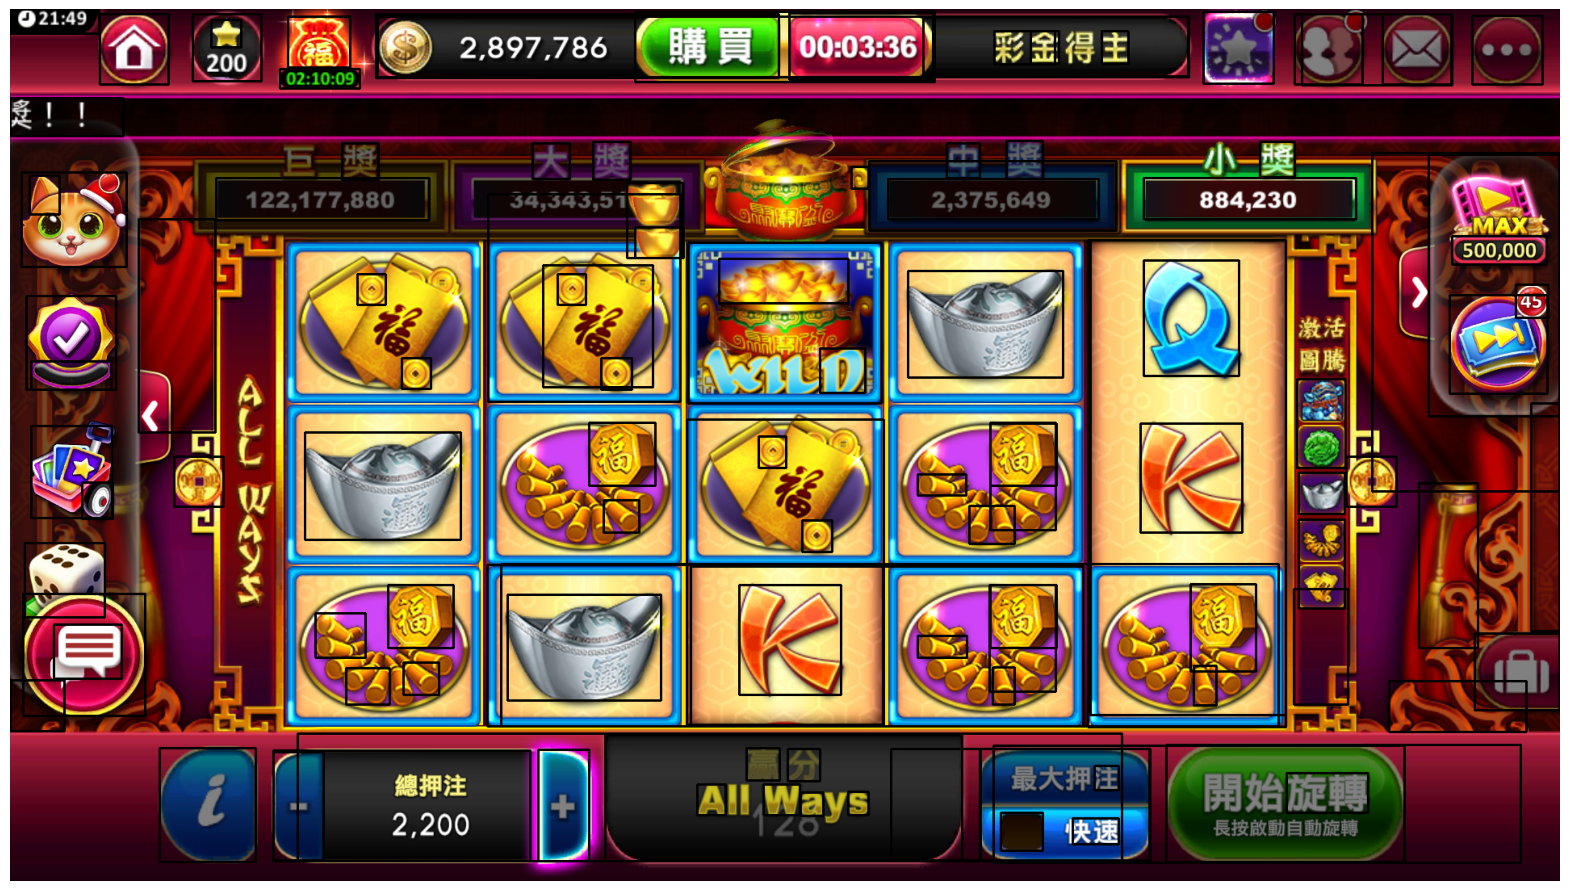

In [8]:
print(f'before merge: {len(masks)}')
masks = merge_mask(masks, tolerance=10)
print(f'after merge: {len(masks)}')
image_copy = image.copy()
draw_bbox(image_copy, masks)
plt.figure(figsize=(20,20))
plt.imshow(image_copy)
plt.axis('off')
plt.show()

In [33]:
def match_symbol_with_segmentation(matching_threshold=0.5, aspect_ratio_threshold=2.0, min_mask_area=5000):

    matched_positions = []

    for mask in masks:
        # Extract the bounding box from the mask
        bbox = mask['bbox']
        x, y, w, h = map(int, bbox)
        aspect_ratio_mask = w / h
        
        mask_area = w * h
        if mask_area < min_mask_area:
            continue

        # Extract the bbox image from the original image
        bbox_image = image_copy[y:y+h, x:x+w, :]
        # cv2.imshow('bbox_image', bbox_image)
        
        # Apply the segmentation mask to the bbox_image
        segmentation_mask = mask['segmentation'][y:y+h, x:x+w]
        segmentation_mask_3c = np.stack([segmentation_mask]*3, axis=-1)
        masked_bbox_image = np.where(segmentation_mask_3c, bbox_image, 0)

        for template_path in template_paths:
            template = cv2.imread(str(template_path), cv2.IMREAD_UNCHANGED)
            alpha_channel = template[:, :, 3]
            template_rgb = template[:, :, :3]
            h_templ, w_templ, _ = template.shape
            aspect_ratio_template = w_templ / h_templ

            # Calculate aspect ratio error
            aspect_ratio_error = abs(aspect_ratio_mask - aspect_ratio_template) / aspect_ratio_template
            if aspect_ratio_error > aspect_ratio_threshold:
                continue
            
            # resize template to match bbox_image's width or height
            if aspect_ratio_template > aspect_ratio_mask:
                # Template is wider; resize template to match bbox_image's width
                scale = w / w_templ
                new_w = w  # Match width of bbox_image
                new_h = int(h_templ * scale)
            else:
                # Template is taller; resize template to match bbox_image's height
                scale = h / h_templ
                new_w = int(w_templ * scale)
                new_h = h  # Match height of bbox_image
            resized_template = cv2.resize(template_rgb, (new_w, new_h), interpolation=cv2.INTER_AREA)
            resized_alpha = cv2.resize(alpha_channel, (new_w, new_h), interpolation=cv2.INTER_AREA)
            
            # ROI in the resized image where template matching will be applied
            roi = masked_bbox_image.copy()

            # Ensure the data types match
            if roi.dtype != resized_template.dtype:
                roi = roi.astype(resized_template.dtype)

            # Apply template matching
            result = cv2.matchTemplate(roi, resized_template, cv2.TM_CCOEFF_NORMED)
            _, max_val, _, max_loc = cv2.minMaxLoc(result)
            # print(max_val)
            
            # Check if the match score exceeds the threshold
            if max_val > matching_threshold:
                print(f"Good match with template '{template_path.name}' at position {max_loc} with score {max_val}")
                matched_x = x + max_loc[0] + new_w // 2
                matched_y = y + max_loc[1] + new_h // 2
                matched_positions.append((matched_x, matched_y))
                cv2.imshow('roi', roi)
                cv2.imshow('template', resized_template)
                cv2.waitKey(0)
                cv2.destroyAllWindows()
    return matched_positions
                
image_copy = cv2.cvtColor(image.copy(), cv2.COLOR_RGB2BGR)
template_dir = Path(f'../images/{GAME_NAME}/symbols')
template_paths = list(template_dir.glob('*'))

matched_positions = match_symbol_with_segmentation()

print(f'total masks: {len(masks)}')
print(f'matched masks: {len(matched_positions)}')

Good match with template 'symbol_11.png' at position (1, 0) with score 0.904435396194458
Good match with template 'symbol_10.png' at position (1, 0) with score 0.9177286028862
Good match with template 'symbol_4.png' at position (0, 1) with score 0.8714603185653687
Good match with template 'symbol_4.png' at position (0, 1) with score 0.8849209547042847
Good match with template 'symbol_4.png' at position (0, 2) with score 0.875756025314331
Good match with template 'symbol_10.png' at position (0, 1) with score 0.929279088973999
total masks: 121
matched masks: 6


In [30]:
# show all matched masks and their centers

image_copy = cv2.cvtColor(image.copy(), cv2.COLOR_RGB2BGR)
for x, y in matched_positions:
    cv2.circle(image_copy, (x, y), 10, (0, 255, 0), -1)
image_copy = cv2.resize(image_copy, (image_copy.shape[1]//2, image_copy.shape[0]//2))
cv2.imshow('matched', image_copy)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [26]:
grid_bbox, grid_shape = get_grid_info(matched_positions)
x, y, w, h = grid_bbox
print(grid_bbox)
print(grid_shape)

image_copy = cv2.cvtColor(image.copy(), cv2.COLOR_RGB2BGR)
symbol_ROIs = get_symbol_ROI(grid_bbox, grid_shape)
for bbox in symbol_ROIs:
    x, y, w, h = bbox
    cv2.rectangle(image_copy, (x, y), (x + w, y + h), (0, 0, 255), 3)

w, h, _ = image_copy.shape
image_copy = cv2.resize(image_copy, (h // 2, w // 2))
cv2.imshow('Symbol ROI', image_copy)
cv2.waitKey(0)
cv2.destroyAllWindows()

(335, 285, 1253, 601)
(3, 5)


In [14]:
# save all segmentation bbox as png

def save_bboxes_as_png(image, masks, output_folder='bbox'):
    # 確保輸出資料夾存在
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # 遍歷每個 mask 並使用提供的 bounding box 資訊
    for i, mask in enumerate(masks):
        # 提取 mask 的 bounding box
        x, y, w, h = map(int, mask['bbox'])

        # 在原始圖片上繪製 bounding box
        bbox_image = cv2.cvtColor(image[y:y+h, x:x+w, :], cv2.COLOR_RGB2BGR)

        # 儲存圖片
        output_path = os.path.join(output_folder, f'bbox_{i}.png')
        cv2.imwrite(output_path, bbox_image)
        
# image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
save_bboxes_as_png(image, masks, f'../images/{GAME_NAME}/bbox')